# Psychological State Identification using Bayesian Networks
This notebook implements the Bayesian Network approach described in the project document
to classify psychological states (Stressed, Relaxed, Focused, Anxious) based on
simulated multimodal data from the [Kaggle dataset](https://www.kaggle.com/datasets/ziya07/psychological-state-identification-dataset).
# Methodology:
1. Load and preprocess the data.
2. Perform feature extraction and encoding.
3. Split data into training and testing sets.
4. Learn the Bayesian Network structure using Hill Climbing with BIC score.
5. Learn the parameters (CPDs) using Maximum Likelihood Estimation (MLE).
6. Perform inference on the test set using Variable Elimination.
7. Evaluate the model's classification performance.
8. Visualize the learned network structure.

## 1. Setup and Imports
Import necessary libraries. Ensure you have `pgmpy`, `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, and `networkx` installed.


In [14]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer # to help discretize continuous numerical features (HRV, GSR, etc.) *before* training
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
)
from sklearn.preprocessing import label_binarize

# pgmpy imports
from pgmpy.models import DiscreteBayesianNetwork # ImportError: BayesianNetwork has been deprecated. Please use DiscreteBayesianNetwork instead.
from pgmpy.estimators import HillClimbSearch, BIC, MaximumLikelihoodEstimator, K2 # BIC instead of BicScore, for some reason pgmpy docs are outdated wtf
from pgmpy.inference import VariableElimination

import pgmpy.estimators
import pgmpy
import sys

print("pgmpy version:", pgmpy.__version__)
print("Python version:", sys.version)
print("\nContents of pgmpy.estimators:")
print(dir(pgmpy.estimators))

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning) # pgmpy might raise UserWarnings about state names


pgmpy version: 1.0.0
Python version: 3.13.3 (main, Apr  9 2025, 07:44:25) [GCC 14.2.1 20250207]

Contents of pgmpy.estimators:
['AIC', 'AICCondGauss', 'AICGauss', 'BDeu', 'BDs', 'BIC', 'BICCondGauss', 'BICGauss', 'BaseEstimator', 'BayesianEstimator', 'CITests', 'EM', 'ExhaustiveSearch', 'ExpectationMaximization', 'ExpertInLoop', 'ExpertKnowledge', 'GES', 'HillClimbSearch', 'IVEstimator', 'K2', 'LinearModel', 'LogLikelihoodCondGauss', 'LogLikelihoodGauss', 'MLE', 'MarginalEstimator', 'MaximumLikelihoodEstimator', 'MirrorDescentEstimator', 'MmhcEstimator', 'PC', 'ParameterEstimator', 'SEMEstimator', 'ScoreCache', 'StructureEstimator', 'StructureScore', 'TreeSearch', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'base', 'expert', 'get_scoring_method']


## 2. Data Loading and Initial Exploration

In [31]:
DATASET_PATH = 'psychological_state_dataset.csv'
TARGET_VARIABLE = 'Psychological State'
TEST_SIZE = 0.20
RANDOM_STATE = 21 # for reproducibility
N_BINS = 2 # Number of bins for discretizing continuous features

# --- Load Data ---
try:
    df = pd.read_csv(DATASET_PATH)
    print("Dataset loaded successfully.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: Dataset file not found at {DATASET_PATH}")
    print("Please update the DATASET_PATH variable.")
    # Exit or raise error if file not found
    exit() # Or raise FileNotFoundError("Dataset file not found")

# Display basic info and first few rows
print("\nDataset Info:")
df.info()

print("\nFirst 5 rows:")
print(df.head())

# Check for missing values (as per document, none are expected in relevant columns)
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset loaded successfully.
Shape: (1000, 20)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      1000 non-null   int64  
 1   Time                    1000 non-null   object 
 2   HRV (ms)                1000 non-null   float64
 3   GSR (μS)                1000 non-null   float64
 4   EEG Power Bands         1000 non-null   object 
 5   Blood Pressure (mmHg)   1000 non-null   object 
 6   Oxygen Saturation (%)   1000 non-null   float64
 7   Heart Rate (BPM)        1000 non-null   int64  
 8   Ambient Noise (dB)      1000 non-null   float64
 9   Cognitive Load          1000 non-null   object 
 10  Mood State              1000 non-null   object 
 11  Psychological State     1000 non-null   object 
 12  Respiration Rate (BPM)  1000 non-null   int64  
 13  Skin Temp (°C)          1000 non

## 3. Data Preprocessing and Feature Engineering
- Extract features from 'EEG Power Bands' and 'Blood Pressure (mmHg)'.
- Drop columns not used for modeling ('ID', 'Time', 'Study Major').
- Encode categorical features using Label Encoding.

In [32]:
# Split 'EEG Power Bands' (assuming comma-separated string or list-like string)
try:
    if isinstance(df['EEG Power Bands'].iloc[0], str):
        df['EEG Power Bands'] = df['EEG Power Bands'].str.replace(r'[\[\]]', '', regex=True)
        eeg_split = df['EEG Power Bands'].str.split(',', expand=True).astype(float)
    else:
        eeg_split = pd.DataFrame(df['EEG Power Bands'].tolist(), index=df.index).astype(float) # Ensure float

    eeg_split.columns = ['EEG_Delta', 'EEG_Alpha', 'EEG_Beta']
    df = pd.concat([df, eeg_split], axis=1)
    print("EEG features extracted.")
except Exception as e:
    print(f"Error extracting EEG features: {e}. Check the format of 'EEG Power Bands'.")
    # Fallback or exit if critical
    df[['EEG_Delta', 'EEG_Alpha', 'EEG_Beta']] = np.nan

# Split 'Blood Pressure (mmHg)' (assuming format 'Sys/Dias')
try:
    bp_split = df['Blood Pressure (mmHg)'].str.split('/', expand=True).astype(float)
    bp_split.columns = ['BP_Systolic', 'BP_Diastolic']
    df = pd.concat([df, bp_split], axis=1)
    print("Blood Pressure features extracted.")
except Exception as e:
    print(f"Error extracting Blood Pressure features: {e}. Check the format of 'Blood Pressure (mmHg)'.")
    # Fallback or exit
    df[['BP_Systolic', 'BP_Diastolic']] = np.nan


# --- Drop Original and Unused Columns ---
columns_to_drop = ['ID', 'Time', 'Study Major', 'EEG Power Bands', 'Blood Pressure (mmHg)']
# Check if columns exist before dropping
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df_processed = df.drop(columns=columns_to_drop) # Create a new df for processing
print(f"Dropped columns: {columns_to_drop}")


# --- Identify Feature Types (Post-Extraction) ---
categorical_cols = df_processed.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=np.number).columns.tolist()

# Ensure target is treated as categorical if it's not already
if TARGET_VARIABLE in numerical_cols:
    numerical_cols.remove(TARGET_VARIABLE)
if TARGET_VARIABLE not in categorical_cols:
     categorical_cols.append(TARGET_VARIABLE) # Add target to categorical list for encoding later

# Handle potential NaNs introduced during feature extraction
df_processed[numerical_cols] = df_processed[numerical_cols].fillna(df_processed[numerical_cols].median())

print(f"\nOriginal Categorical columns: {categorical_cols}")
print(f"Numerical columns to discretize: {numerical_cols}")


# --- Data Splitting (BEFORE Discretization & Encoding) ---
# We split first to fit discretizer and encoders only on training data
X = df_processed.drop(TARGET_VARIABLE, axis=1)
y = df_processed[TARGET_VARIABLE]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y # Stratify based on the original categorical target
)

print(f"\nTraining data shape (before discretization/encoding): {X_train.shape}")
print(f"Testing data shape (before discretization/encoding): {X_test.shape}")

# --- Discretization (Optional - Fit on Train, Transform Train & Test) ---
# If needed, numerical columns could be discretized here using pd.cut or KBinsDiscretizer
# For now, we assume the pgmpy estimators can handle continuous/mixed data or implicitly discretize.
# Note: Some pgmpy structure learning algorithms strictly require discrete data.
# HillClimbSearch with BIC score can sometimes handle continuous, but results may vary.
# If structure learning fails, discretization might be necessary.
print(f"\nDiscretizing numerical features into {N_BINS} bins...")
discretizer = KBinsDiscretizer(n_bins=N_BINS, encode='ordinal', strategy='uniform', subsample=None) # Use uniform for simplicity, quantile is also optional

# Fit ONLY on the numerical columns of the training data
discretizer.fit(X_train[numerical_cols])

# Transform numerical columns in both training and testing sets
X_train_num_discretized = discretizer.transform(X_train[numerical_cols])
X_test_num_discretized = discretizer.transform(X_test[numerical_cols])

# Convert the discretized arrays back to DataFrames with appropriate column names
X_train_num_discretized_df = pd.DataFrame(X_train_num_discretized, columns=numerical_cols, index=X_train.index).astype(int)
X_test_num_discretized_df = pd.DataFrame(X_test_num_discretized, columns=numerical_cols, index=X_test.index).astype(int)

print("Discretization complete.")
# print("Example discretized training data (first 5 rows, numerical cols):")
# print(X_train_num_discretized_df.head())


# --- Combine Discretized Numerical and Original Categorical Features ---
# Drop original numerical columns and join discretized ones
X_train_processed = X_train.drop(columns=numerical_cols).join(X_train_num_discretized_df)
X_test_processed = X_test.drop(columns=numerical_cols).join(X_test_num_discretized_df)

# Include the target variable (still in its original form) for encoding
train_data_to_encode = X_train_processed.join(y_train)
test_data_to_encode = X_test_processed.join(y_test)

print("\nCombined feature types before final encoding:")
print(train_data_to_encode.info())


# --- Label Encoding (Applied to ALL Columns now) ---
# All features (original categorical + newly discretized numerical) and the target variable
# need to be integer encoded for pgmpy's DiscreteBayesianNetwork.
print("\nStarting Label Encoding for all features...")
label_encoders = {}
train_data_encoded = train_data_to_encode.copy()
test_data_encoded = test_data_to_encode.copy()

all_cols_to_encode = train_data_encoded.columns.tolist()

for col in all_cols_to_encode:
    le = LabelEncoder()
    # Combine train and test for fitting encoder to capture all possible states
    combined_col_data = pd.concat([train_data_encoded[col], test_data_encoded[col]], axis=0).astype(str)
    le.fit(combined_col_data)

    # Transform train and test separately
    train_data_encoded[col] = le.transform(train_data_encoded[col].astype(str))
    test_data_encoded[col] = le.transform(test_data_encoded[col].astype(str))

    label_encoders[col] = le
    print(f"Encoded column: {col}")
    # Store mapping for clarity (only if few categories, else it's too long)
    if len(le.classes_) <= 15:
         mapping = dict(zip(le.classes_, le.transform(le.classes_)))
         print(f"  Mapping: {mapping}")

print("\nLabel Encoding complete.")
print("\nFinal Training Data (encoded):")
print(train_data_encoded.head())
print("\nFinal Training Data Info:")
print(train_data_encoded.info())


# Assign final encoded dataframes
train_data = train_data_encoded
test_data = test_data_encoded

EEG features extracted.
Blood Pressure features extracted.
Dropped columns: ['ID', 'Time', 'Study Major', 'EEG Power Bands', 'Blood Pressure (mmHg)']

Original Categorical columns: ['Cognitive Load', 'Mood State', 'Psychological State', 'Task Type', 'Gender', 'Educational Level']
Numerical columns to discretize: ['HRV (ms)', 'GSR (μS)', 'Oxygen Saturation (%)', 'Heart Rate (BPM)', 'Ambient Noise (dB)', 'Respiration Rate (BPM)', 'Skin Temp (°C)', 'Focus Duration (s)', 'Age', 'EEG_Delta', 'EEG_Alpha', 'EEG_Beta', 'BP_Systolic', 'BP_Diastolic']

Training data shape (before discretization/encoding): (800, 19)
Testing data shape (before discretization/encoding): (200, 19)

Discretizing numerical features into 2 bins...
Discretization complete.

Combined feature types before final encoding:
<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 169 to 559
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  -----

## 4. Data Splitting (verification since splitting done above)
Split the encoded data into training (80%) and testing (20%) sets.


In [33]:
print(f"Final Training data shape: {train_data.shape}")
print(f"Final Testing data shape: {test_data.shape}")

# Verify target variable distribution in encoded data (optional)
print("\nTarget variable distribution in training data (encoded):")
print(train_data[TARGET_VARIABLE].value_counts(normalize=True))
print("\nTarget variable distribution in testing data (encoded):")
print(test_data[TARGET_VARIABLE].value_counts(normalize=True))


Final Training data shape: (800, 20)
Final Testing data shape: (200, 20)

Target variable distribution in training data (encoded):
Psychological State
3    0.26250
1    0.24875
2    0.24750
0    0.24125
Name: proportion, dtype: float64

Target variable distribution in testing data (encoded):
Psychological State
3    0.265
1    0.250
2    0.245
0    0.240
Name: proportion, dtype: float64


## 5. Bayesian Network Structure Learning
Learn the DAG structure from the training data using the Hill Climbing search algorithm and BIC score.


In [44]:
print("Starting structure learning (this may take some time)...")

# Initialize scoring method and search algorithm
# bic_scorer = BIC(data=train_data)
k2_scorer = K2(data=train_data)
hc = HillClimbSearch(data=train_data)

# Perform the search
# `max_indegree` can be used to limit complexity if needed
# Ensure all data is integer type for estimators
train_data = train_data.astype(int)
best_model_structure = hc.estimate(
    scoring_method=k2_scorer, # Pass the BIC instance
    # max_indegree=None, # Optional: Limit parent count per node
    # black_list=None, # Optional: Prevent specific edges
    # white_list=None, # Optional: Force specific edges
    show_progress=True # Set to False to hide progress bar if running non-interactively
)
print(f"Learned Edges: {list(best_model_structure.edges())}")

print("\nStructure learning complete.")
print(f"Learned Edges ({len(best_model_structure.edges())}):")
# Print edges for inspection (can be numerous)
# print(sorted(list(best_model_structure.edges())))

# Create the Bayesian Network model with the learned structure
model = DiscreteBayesianNetwork(best_model_structure.edges())
model.add_nodes_from(train_data.columns) # Ensure all nodes are included

print(f"\nModel nodes ({len(model.nodes())}): {model.nodes()}")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Cognitive Load': 'N', 'Mood State': 'N', 'Task Type': 'N', 'Gender': 'N', 'Educational Level': 'N', 'HRV (ms)': 'N', 'GSR (μS)': 'N', 'Oxygen Saturation (%)': 'N', 'Heart Rate (BPM)': 'N', 'Ambient Noise (dB)': 'N', 'Respiration Rate (BPM)': 'N', 'Skin Temp (°C)': 'N', 'Focus Duration (s)': 'N', 'Age': 'N', 'EEG_Delta': 'N', 'EEG_Alpha': 'N', 'EEG_Beta': 'N', 'BP_Systolic': 'N', 'BP_Diastolic': 'N', 'Psychological State': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Cognitive Load': 'N', 'Mood State': 'N', 'Task Type': 'N', 'Gender': 'N', 'Educational Level': 'N', 'HRV (ms)': 'N', 'GSR (μS)': 'N', 'Oxygen Saturation (%)': 'N', 'Heart Rate (BPM)': 'N', 'Ambient Noise (dB)': 'N', 'Respiration Rate (BPM)': 'N', 'Skin Temp (°C)': 'N', 'Focus Duration (s)': 'N', 'Age': 'N', 'EEG_Delta': 'N', 'EEG_Alpha': 'N', 'EEG_Beta'

Starting structure learning (this may take some time)...


  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned Edges: [('Respiration Rate (BPM)', 'Skin Temp (°C)')]

Structure learning complete.
Learned Edges (1):

Model nodes (20): ['Respiration Rate (BPM)', 'Skin Temp (°C)', 'Cognitive Load', 'Mood State', 'Task Type', 'Gender', 'Educational Level', 'HRV (ms)', 'GSR (μS)', 'Oxygen Saturation (%)', 'Heart Rate (BPM)', 'Ambient Noise (dB)', 'Focus Duration (s)', 'Age', 'EEG_Delta', 'EEG_Alpha', 'EEG_Beta', 'BP_Systolic', 'BP_Diastolic', 'Psychological State']


## 6. Bayesian Network Parameter Learning
Estimate the Conditional Probability Distributions (CPDs) for each node in the learned structure using Maximum Likelihood Estimation (MLE) on the training data.


In [45]:
print("Starting parameter learning (MLE)...")

# Fit the model using MLE
# state_names can be provided if LabelEncoder wasn't used, but it should infer from data
model.fit(
    data=train_data,
    estimator=MaximumLikelihoodEstimator
    # state_names={col: list(label_encoders[col].classes_) for col in categorical_cols if col in label_encoders} # Optional: provide explicit names
)

print("Parameter learning complete.")

# --- Model Validation (Basic Checks) ---
print("\nChecking model structure and parameters...")
try:
    model.check_model()
    print("Model check successful: Structure is valid and CPDs sum to 1.")
except Exception as e:
    print(f"Model check failed: {e}")

# Optionally, print a few CPDs to inspect
print("\nExample CPDs (first 3):")
cpd_count = 0
for cpd in model.get_cpds()[:3]:
    print(f"\nCPD for variable: {cpd.variable}")
    print(cpd)
    cpd_count += 1
if cpd_count == 0:
    print("No CPDs found (check fitting process).")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Cognitive Load': 'N', 'Mood State': 'N', 'Task Type': 'N', 'Gender': 'N', 'Educational Level': 'N', 'HRV (ms)': 'N', 'GSR (μS)': 'N', 'Oxygen Saturation (%)': 'N', 'Heart Rate (BPM)': 'N', 'Ambient Noise (dB)': 'N', 'Respiration Rate (BPM)': 'N', 'Skin Temp (°C)': 'N', 'Focus Duration (s)': 'N', 'Age': 'N', 'EEG_Delta': 'N', 'EEG_Alpha': 'N', 'EEG_Beta': 'N', 'BP_Systolic': 'N', 'BP_Diastolic': 'N', 'Psychological State': 'N'}


Starting parameter learning (MLE)...
Parameter learning complete.

Checking model structure and parameters...
Model check successful: Structure is valid and CPDs sum to 1.

Example CPDs (first 3):

CPD for variable: Respiration Rate (BPM)
+---------------------------+---------+
| Respiration Rate (BPM)(0) | 0.44625 |
+---------------------------+---------+
| Respiration Rate (BPM)(1) | 0.55375 |
+---------------------------+---------+

CPD for variable: Skin Temp (°C)
+------------------------+-----+---------------------------+
| Respiration Rate (BPM) | ... | Respiration Rate (BPM)(1) |
+------------------------+-----+---------------------------+
| Skin Temp (°C)(0)      | ... | 0.5575620767494357        |
+------------------------+-----+---------------------------+
| Skin Temp (°C)(1)      | ... | 0.44243792325056436       |
+------------------------+-----+---------------------------+

CPD for variable: Cognitive Load
+-------------------+---------+
| Cognitive Load(0) | 0.3375  |
+-

## 7. Inference and Prediction on Test Set
Use the learned model to predict the psychological state for each instance in the test set. We use the Variable Elimination algorithm for exact inference.


In [46]:
print("Starting inference on the test set...")

# Prepare test data for prediction (remove target variable)
X_test_encoded = test_data.drop(columns=[TARGET_VARIABLE])
y_test_encoded = test_data[TARGET_VARIABLE] # Keep encoded target for evaluation

# Initialize inference engine
inference_engine = VariableElimination(model)

# Predict probabilities for each class
y_pred_probs = None 
y_pred_labels_encoded = []

# Store original decoded labels for final report
y_test_labels = label_encoders[TARGET_VARIABLE].inverse_transform(y_test_encoded)


# Attempt batch prediction (should work better with discrete data)
try:
    print("Attempting batch prediction...")
    # Ensure columns match the order expected by the model
    X_test_encoded = X_test_encoded[list(X_train_processed.columns)] # Ensure same column order as training

    # Predict most likely state (encoded)
    y_pred_encoded_df = model.predict(X_test_encoded, n_jobs=-1)
    y_pred_labels_encoded = y_pred_encoded_df[TARGET_VARIABLE].values

    # Predict probabilities
    print("Predicting probabilities...")
    y_pred_probs_df = model.predict_probability(X_test_encoded, n_jobs=-1)

    # Ensure probability columns are in the correct order of original classes
    ordered_classes_encoded = label_encoders[TARGET_VARIABLE].transform(label_encoders[TARGET_VARIABLE].classes_)
    prob_cols_ordered = [f"{TARGET_VARIABLE}_{enc_val}" for enc_val in sorted(ordered_classes_encoded)] # pgmpy uses TARGET_encodedvalue

    # Check if columns exist and extract in correct order
    available_cols = y_pred_probs_df.columns.tolist()
    cols_to_use = [col for col in prob_cols_ordered if col in available_cols]
    missing_cols = [col for col in prob_cols_ordered if col not in available_cols]

    if missing_cols:
        print(f"Warning: Expected probability columns missing: {missing_cols}")
        # Handle missing columns if necessary (e.g., assign zero probability)
        # For simplicity, we'll proceed with available columns, but AUC might be affected
        y_pred_probs = y_pred_probs_df[cols_to_use].values
        # Need to ensure y_pred_probs has the right shape for roc_auc_score later
        # Pad with zeros for missing classes if needed (complex to get right order)
        # For now, set to None to skip AUC if columns are missing
        print("Setting probabilities to None due to missing columns.")
        y_pred_probs = None

    else:
         y_pred_probs = y_pred_probs_df[cols_to_use].values

    print("Batch prediction successful.")

except Exception as e:
    print(f"An unexpected error occurred during batch prediction ({e}), falling back to row-by-row inference (slower)...")
    # Fallback code
    y_pred_probs_list = []
    y_pred_labels_encoded = [] # Store encoded labels first
    for index, row in X_test_encoded.iterrows():
        try:
            evidence = row.to_dict()
            # Ensure evidence values are integers
            evidence = {k: int(v) for k, v in evidence.items()}
            prob_dist = inference_engine.query(variables=[TARGET_VARIABLE], evidence=evidence, show_progress=False)
            probs = prob_dist.values
            predicted_state_encoded = np.argmax(probs)
            y_pred_labels_encoded.append(predicted_state_encoded)
            y_pred_probs_list.append(probs)
        except Exception as query_error:
            print(f"Error during inference for row {index}: {query_error}")
            y_pred_labels_encoded.append(np.nan) # Use NaN for error
            num_classes = len(label_encoders[TARGET_VARIABLE].classes_)
            y_pred_probs_list.append([np.nan] * num_classes) # Placeholder probs

    y_pred_probs = np.array(y_pred_probs_list)
    y_pred_labels_encoded = np.array(y_pred_labels_encoded) # Convert list to array


print("Inference complete.")

# Decode predicted labels (handle potential NaNs from errors)
valid_preds_indices = ~np.isnan(y_pred_labels_encoded)
y_pred_labels = np.full(len(y_test_labels), fill_value='Error', dtype=object) # Initialize with placeholder
if np.any(valid_preds_indices):
     valid_preds_encoded = y_pred_labels_encoded[valid_preds_indices].astype(int)
     y_pred_labels[valid_preds_indices] = label_encoders[TARGET_VARIABLE].inverse_transform(valid_preds_encoded)

# print(f"First 5 predictions (decoded): {y_pred_labels[:5]}")
# print(f"First 5 actual labels (decoded): {y_test_labels[:5]}")

Starting inference on the test set...
Attempting batch prediction...


  0%|          | 0/200 [00:00<?, ?it/s]

Predicting probabilities...
An unexpected error occurred during batch prediction (DiscreteBayesianNetwork.predict_probability() got an unexpected keyword argument 'n_jobs'), falling back to row-by-row inference (slower)...
Inference complete.


## 8. Model Evaluation
Evaluate the classifier's performance using accuracy, classification report (precision, recall, F1-score), confusion matrix, and AUC (Area Under the ROC Curve) on the **encoded and discretized** data.


Evaluating model performance...

Overall Accuracy: 0.2650

Classification Report:
              precision    recall  f1-score   support

     Anxious       0.00      0.00      0.00        48
     Focused       0.00      0.00      0.00        50
     Relaxed       0.00      0.00      0.00        49
    Stressed       0.27      1.00      0.42        53

    accuracy                           0.27       200
   macro avg       0.07      0.25      0.10       200
weighted avg       0.07      0.27      0.11       200


Confusion Matrix:
[[ 0  0  0 48]
 [ 0  0  0 50]
 [ 0  0  0 49]
 [ 0  0  0 53]]


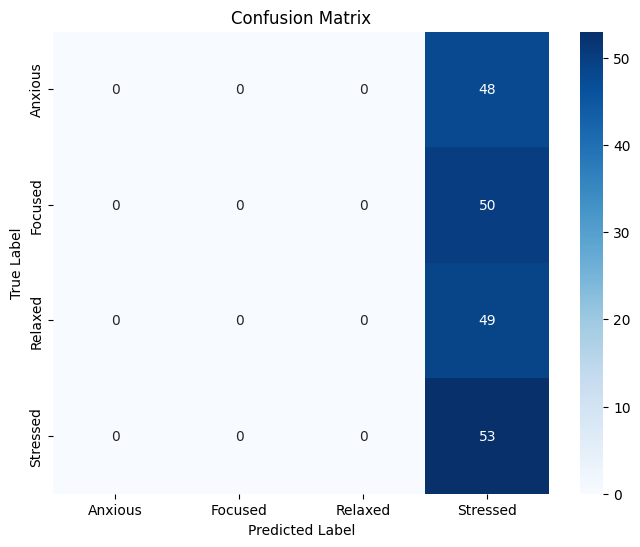


AUC Score (Micro Average, OvR): 0.5133
AUC Score (Macro Average, OvR): 0.5000


/tmp/ipykernel_5767/3367282197.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes) # Get distinct colors


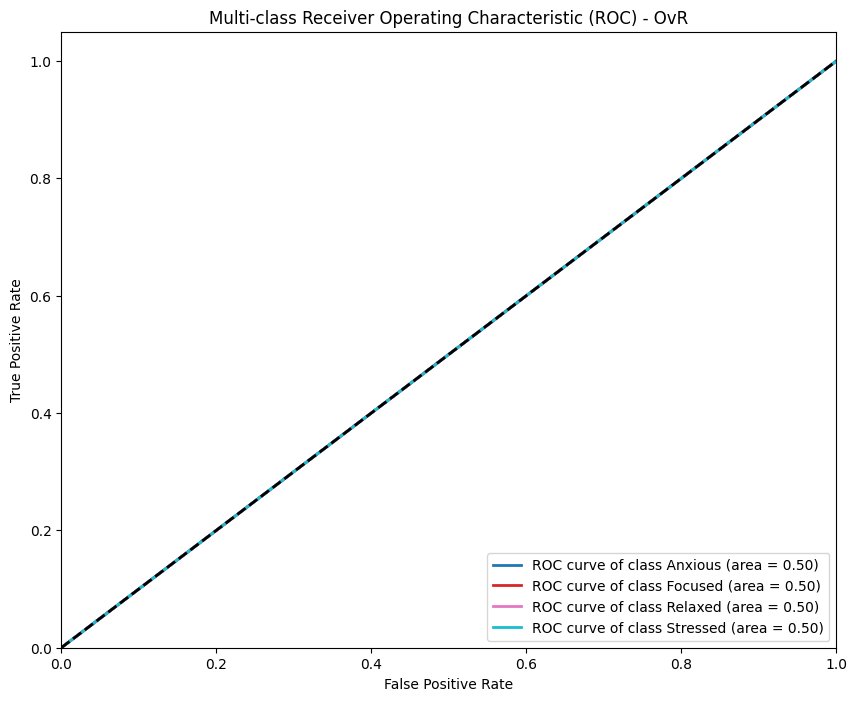

In [47]:
print("Evaluating model performance...")

# Filter out any instances where prediction failed (resulted in 'Error' or NaN)
valid_comparison_indices = (y_pred_labels != 'Error')
y_test_labels_filtered = y_test_labels[valid_comparison_indices]
y_pred_labels_filtered = y_pred_labels[valid_comparison_indices]
y_test_encoded_filtered = y_test_encoded[valid_comparison_indices] # Get corresponding encoded true labels

# Filter probabilities array if it exists and matches length
if y_pred_probs is not None and y_pred_probs.shape[0] == len(valid_comparison_indices):
     # Filter NaNs that might have occurred during row-by-row fallback
     prob_valid_indices = ~np.isnan(y_pred_probs).any(axis=1)
     combined_valid = valid_comparison_indices & prob_valid_indices

     y_pred_probs_filtered = y_pred_probs[combined_valid]
     # Also re-filter labels based on valid probabilities
     y_test_labels_filtered = y_test_labels[combined_valid]
     y_pred_labels_filtered = y_pred_labels[combined_valid]
     y_test_encoded_filtered = y_test_encoded[combined_valid]
else:
     y_pred_probs_filtered = None # Indicate probabilities are unavailable/mismatched
     print("Warning: Probabilities array issue detected. AUC calculation might be skipped.")


if len(y_test_labels_filtered) == 0:
    print("Error: No valid predictions available for evaluation.")
else:
    # --- Accuracy ---
    accuracy = accuracy_score(y_test_labels_filtered, y_pred_labels_filtered)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # --- Classification Report ---
    print("\nClassification Report:")
    # Use the actual labels present in the filtered results for the report
    report_labels = sorted(list(set(y_test_labels_filtered) | set(y_pred_labels_filtered)))
    print(classification_report(y_test_labels_filtered, y_pred_labels_filtered, labels=report_labels, target_names=report_labels, zero_division=0))

    # --- Confusion Matrix ---
    print("\nConfusion Matrix:")
    # Ensure labels for CM are consistent with report_labels
    cm = confusion_matrix(y_test_labels_filtered, y_pred_labels_filtered, labels=report_labels)
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=report_labels, yticklabels=report_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # --- AUC (Area Under the ROC Curve) ---
    n_classes = len(report_labels)
    if n_classes > 1 and y_pred_probs_filtered is not None and y_pred_probs_filtered.shape[0] == len(y_test_encoded_filtered):
        try:
            # Binarize the true labels based on the classes present in the results
            binarizer_classes_encoded = label_encoders[TARGET_VARIABLE].transform(report_labels)
            y_test_binarized = label_binarize(y_test_encoded_filtered, classes=binarizer_classes_encoded)

            # Ensure probabilities match the binarized shape
            if y_test_binarized.shape[1] != y_pred_probs_filtered.shape[1]:
                 print(f"Warning: Shape mismatch between binarized labels ({y_test_binarized.shape}) and probabilities ({y_pred_probs_filtered.shape}). Skipping AUC.")
                 # This can happen if batch probability prediction failed and returned fewer columns
            elif n_classes == 2:
                 # Binary case: Use probability of the positive class
                 positive_class_index = 1 # Index corresponding to the second class in report_labels
                 y_pred_probs_auc = y_pred_probs_filtered[:, positive_class_index]
                 auc_score = roc_auc_score(y_test_binarized.ravel(), y_pred_probs_auc)
                 print(f"\nAUC Score (Binary Case): {auc_score:.4f}")
                 fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_pred_probs_auc)
                 plt.figure(figsize=(7, 5))
                 plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
                 plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                 plt.xlim([0.0, 1.0])
                 plt.ylim([0.0, 1.05])
                 plt.xlabel('False Positive Rate')
                 plt.ylabel('True Positive Rate')
                 plt.title('Receiver Operating Characteristic (ROC) Curve')
                 plt.legend(loc="lower right")
                 plt.show()

            elif n_classes > 2:
                 # Multi-class case: Calculate OvR AUC scores
                 auc_micro = roc_auc_score(y_test_binarized, y_pred_probs_filtered, average='micro', multi_class='ovr')
                 auc_macro = roc_auc_score(y_test_binarized, y_pred_probs_filtered, average='macro', multi_class='ovr')
                 print(f"\nAUC Score (Micro Average, OvR): {auc_micro:.4f}")
                 print(f"AUC Score (Macro Average, OvR): {auc_macro:.4f}")

                 # Plot ROC curve for each class
                 fpr = dict()
                 tpr = dict()
                 roc_auc = dict()
                 plt.figure(figsize=(10, 8))
                 colors = plt.cm.get_cmap('tab10', n_classes) # Get distinct colors

                 for i, class_label in enumerate(report_labels):
                     fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs_filtered[:, i])
                     roc_auc[i] = auc(fpr[i], tpr[i])
                     plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'ROC curve of class {class_label} (area = {roc_auc[i]:.2f})')

                 plt.plot([0, 1], [0, 1], 'k--', lw=2)
                 plt.xlim([0.0, 1.0])
                 plt.ylim([0.0, 1.05])
                 plt.xlabel('False Positive Rate')
                 plt.ylabel('True Positive Rate')
                 plt.title('Multi-class Receiver Operating Characteristic (ROC) - OvR')
                 plt.legend(loc="lower right")
                 plt.show()

        except ValueError as ve:
             print(f"\nCould not calculate AUC due to ValueError: {ve}")
             print("  This often happens if only one class is present in the test labels after filtering, or if probabilities are malformed.")
        except Exception as e:
            print(f"\nCould not calculate AUC due to unexpected error: {e}")

    else:
        print("\nAUC calculation skipped.")
        if n_classes <= 1: print("  Reason: Not enough classes present in results.")
        if y_pred_probs_filtered is None: print("  Reason: Probabilities were not generated or available/valid.")
        elif y_pred_probs_filtered.shape[0] != len(y_test_encoded_filtered): print(f"  Reason: Mismatched shapes - Probs: {y_pred_probs_filtered.shape[0]}, Filtered Labels: {len(y_test_encoded_filtered)}")

## 9. Visualize Learned Network Structure
Display the learned Directed Acyclic Graph (DAG).


Visualizing learned network structure...
Using graphviz layout (neato).


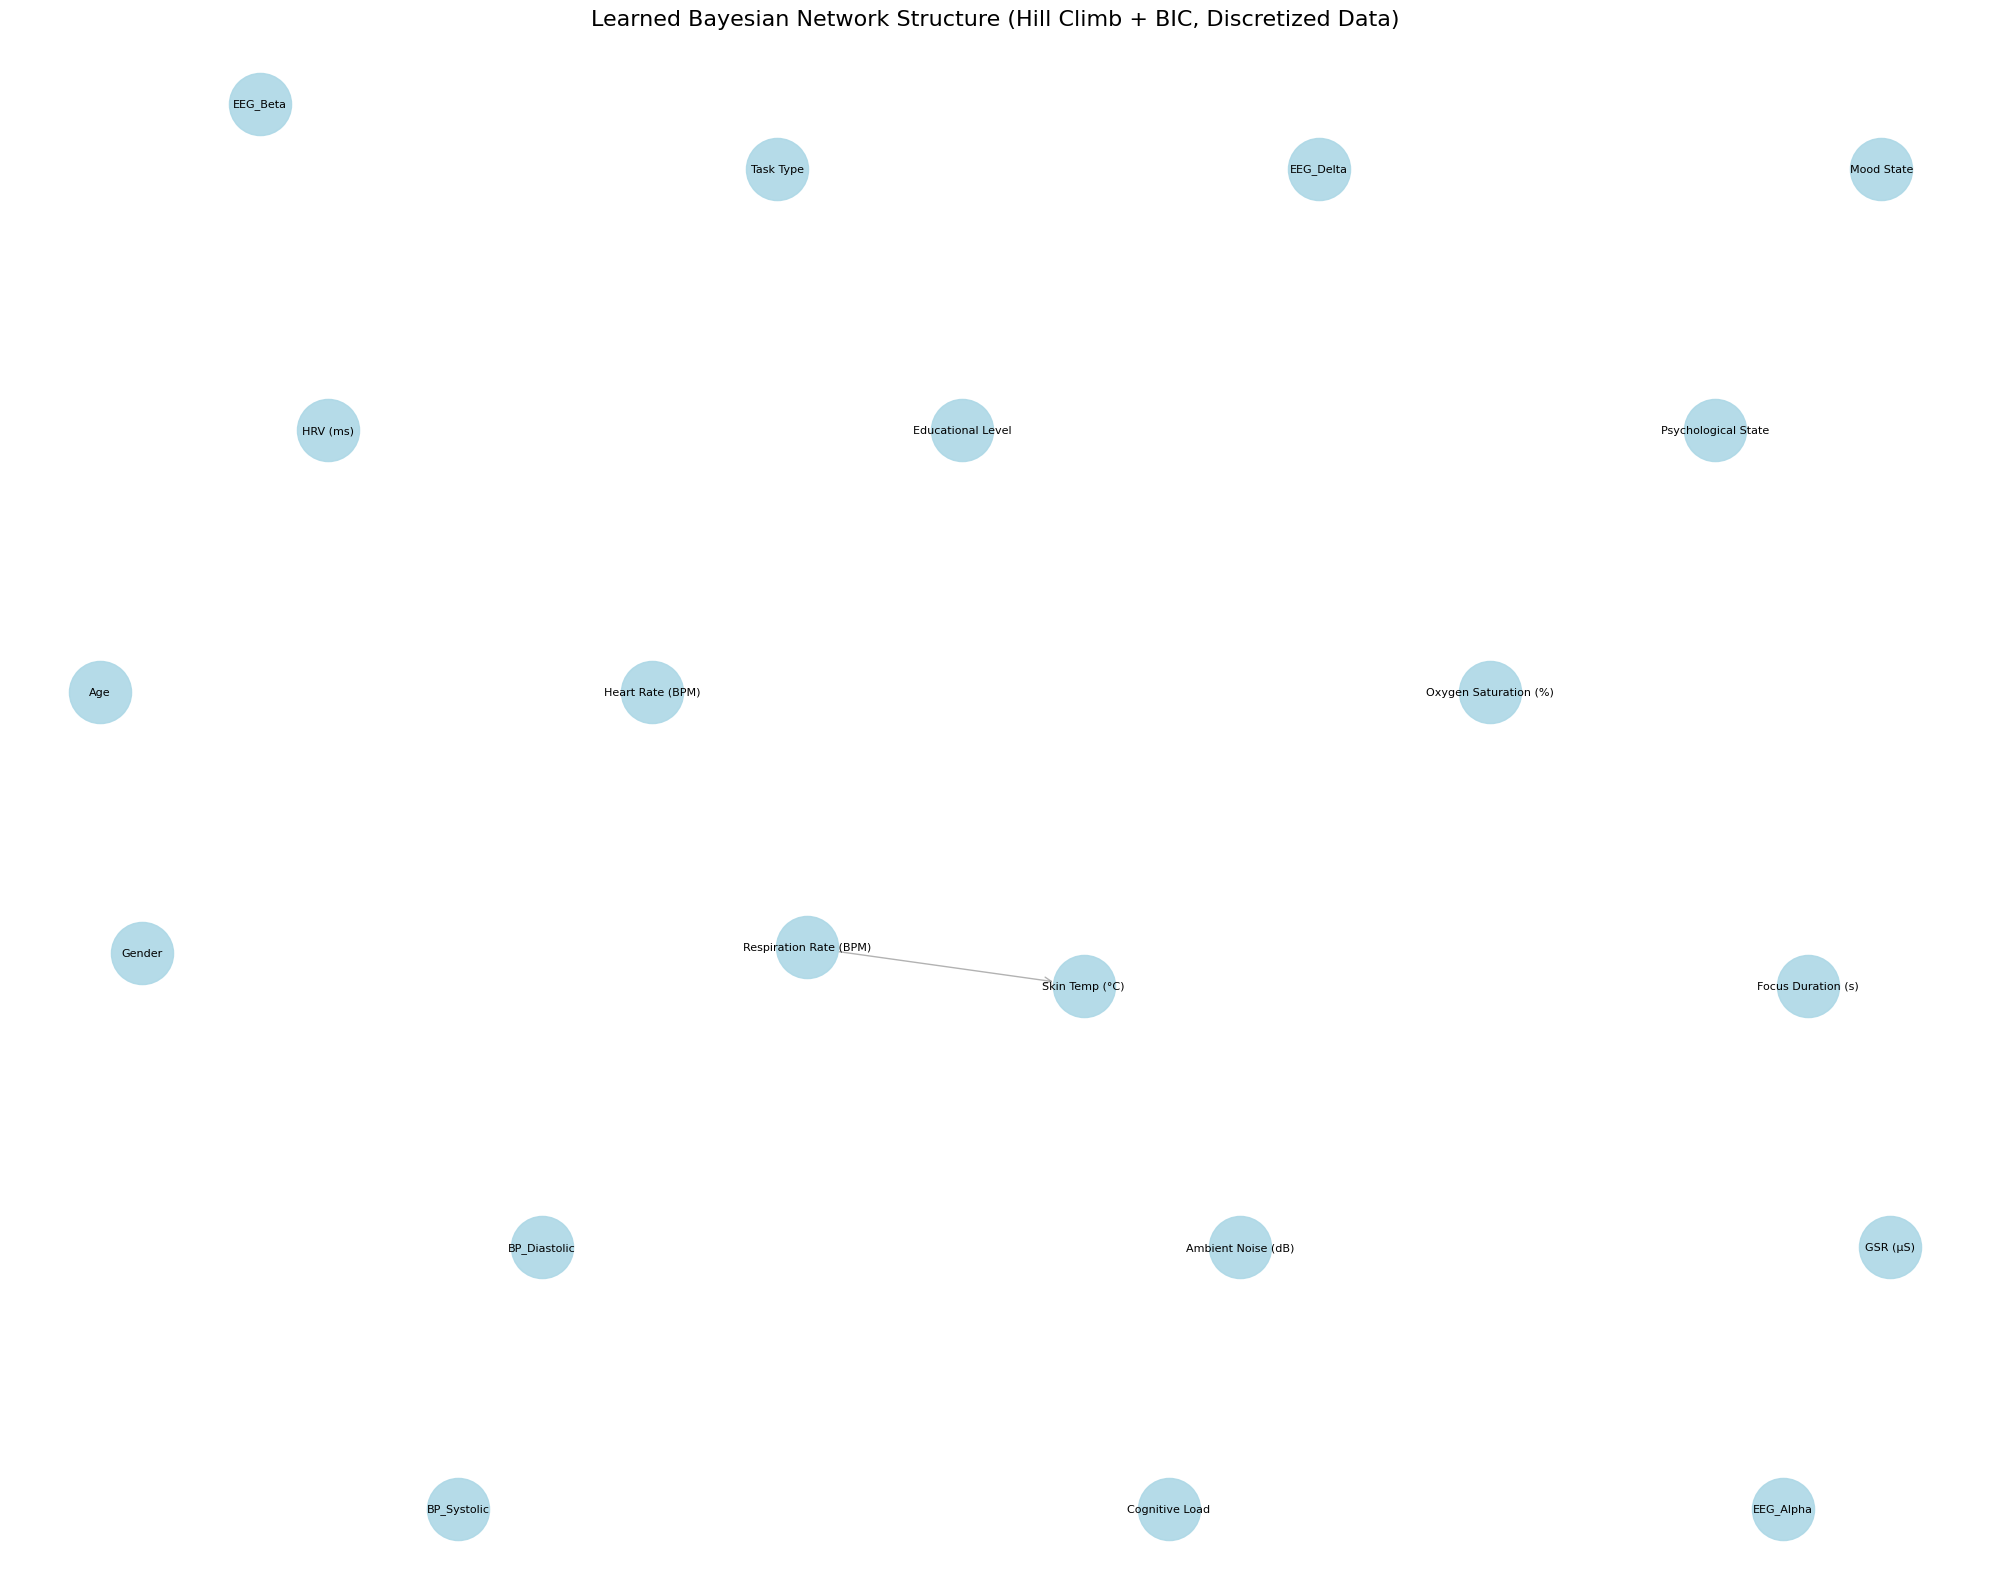

Visualization complete.


In [48]:
print("\nVisualizing learned network structure...")

plt.figure(figsize=(20, 16)) # Increased size for potentially more nodes/edges
try:
    # Use a layout algorithm that handles larger graphs better
    # Requires graphviz and pygraphviz/pydot: `pip install pygraphviz` or `pip install pydot`
    pos = nx.nx_agraph.graphviz_layout(model, prog='neato')
    print("Using graphviz layout (neato).")
except ImportError:
    print("Graphviz/pygraphviz/pydot not found, using alternative layout (kamada_kawai). Install graphviz and pygraphviz or pydot for potentially better layouts.")
    pos = nx.kamada_kawai_layout(model)
except Exception as layout_err:
     print(f"Layout failed ({layout_err}), using basic spring layout.")
     pos = nx.spring_layout(model)


# Draw nodes
nx.draw_networkx_nodes(model, pos, node_size=2000, node_color='lightblue', alpha=0.9)

# Draw edges
nx.draw_networkx_edges(model, pos, edgelist=model.edges(), arrowstyle='->', arrowsize=12, edge_color='gray', alpha=0.6, node_size=2000) # Match node_size

# Draw labels
nx.draw_networkx_labels(model, pos, font_size=8) # Adjusted font size

plt.title("Learned Bayesian Network Structure (Hill Climb + BIC, Discretized Data)", fontsize=16)
plt.axis('off') # Turn off the axis
plt.tight_layout()
plt.show()

print("Visualization complete.")